In [236]:

import requests
import os
from dotenv import load_dotenv
import pandas as pd
import time

load_dotenv()

EIA_KEY = os.getenv("EIA_KEY")

In [237]:
'''url = "https://api.eia.gov/v2/electricity/rto/region-data/data"
all_data = []

for offset in range(0, 20000, 5000):  # Fetch 4 pages: 0, 5000, 10000, 15000
    params = {
        "api_key": EIA_KEY,
        "frequency": "hourly",
        "data[0]": "value",
        "facets[type][]": "D",
        "facets[respondent][]": "ERCO",
        "start": "2024-01-01T00",
        "end": "2024-12-31T00",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": offset,
        "length": 5000
    }

    print(f"Fetching records {offset} to {offset+5000}...")
    response = requests.get(url, params=params)
    if response.status_code == 200:
        batch = response.json().get("response", {}).get("data", [])
        all_data.extend(batch)
        if len(batch) < 5000:
            break  # No more data
    else:
        print("Failed at offset", offset)
        print(response.text)
        break

    time.sleep(1) 

print(f"Total records collected: {len(all_data)}")'''

'url = "https://api.eia.gov/v2/electricity/rto/region-data/data"\nall_data = []\n\nfor offset in range(0, 20000, 5000):  # Fetch 4 pages: 0, 5000, 10000, 15000\n    params = {\n        "api_key": EIA_KEY,\n        "frequency": "hourly",\n        "data[0]": "value",\n        "facets[type][]": "D",\n        "facets[respondent][]": "ERCO",\n        "start": "2024-01-01T00",\n        "end": "2024-12-31T00",\n        "sort[0][column]": "period",\n        "sort[0][direction]": "desc",\n        "offset": offset,\n        "length": 5000\n    }\n\n    print(f"Fetching records {offset} to {offset+5000}...")\n    response = requests.get(url, params=params)\n    if response.status_code == 200:\n        batch = response.json().get("response", {}).get("data", [])\n        all_data.extend(batch)\n        if len(batch) < 5000:\n            break  # No more data\n    else:\n        print("Failed at offset", offset)\n        print(response.text)\n        break\n\n    time.sleep(1) \n\nprint(f"Total reco

In [238]:
'''df_EIA_Demand = pd.DataFrame(all_data)'''


'df_EIA_Demand = pd.DataFrame(all_data)'

In [239]:
df_EIA_Demand = pd.read_csv('./data/raw/EIA_Demand.csv')

In [240]:
df_EIA_Demand

,period,respondent,respondent-name,type,type-name,value,value-units
0,2024-12-31T00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,50098,megawatthours
1,2024-12-30T23,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,50334,megawatthours
2,2024-12-30T22,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,50245,megawatthours
3,2024-12-30T21,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,49602,megawatthours
4,2024-12-30T20,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,48595,megawatthours
...,...,...,...,...,...,...,...
8756,2024-01-01T04,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,43279,megawatthours
8757,2024-01-01T03,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,44012,megawatthours
8758,2024-01-01T02,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,44887,megawatthours
8759,2024-01-01T01,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,45855,megawatthours


In [241]:
df_EIA_Demand.to_csv("./data/raw/EIA_Demand.csv", index=False)

In [242]:
EIA_clean_df = df_EIA_Demand.drop(axis=0, columns={'respondent-name', 'type', 'value-units', 'respondent', 'type-name'})

In [243]:
EIA_clean_df.rename(columns={'value':'demand-mwh'}, inplace=True)
EIA_clean_df

,period,demand-mwh
0,2024-12-31T00,50098
1,2024-12-30T23,50334
2,2024-12-30T22,50245
3,2024-12-30T21,49602
4,2024-12-30T20,48595
...,...,...
8756,2024-01-01T04,43279
8757,2024-01-01T03,44012
8758,2024-01-01T02,44887
8759,2024-01-01T01,45855


In [244]:
EIA_clean_df['period'] = pd.to_datetime(EIA_clean_df['period'],utc=True )
EIA_clean_df = EIA_clean_df.set_index('period').sort_index()


In [245]:
EIA_clean_df['demand-mwh'] = pd.to_numeric(EIA_clean_df['demand-mwh'], errors='coerce')

In [246]:
import matplotlib.pyplot as plt

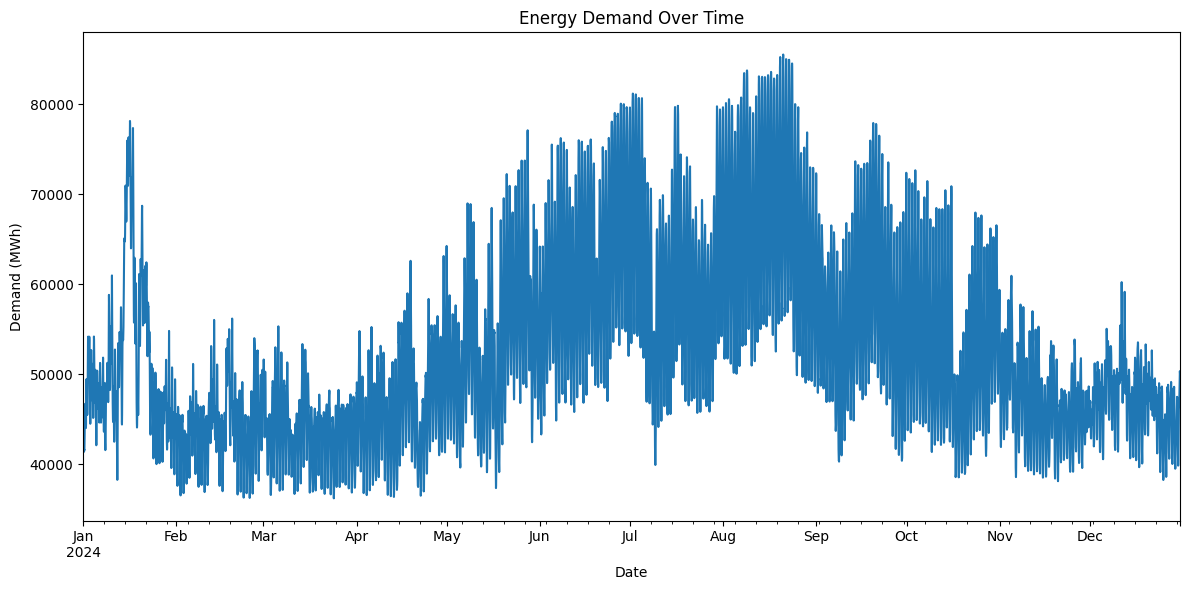

In [247]:
plt.figure(figsize=(12, 6))
EIA_clean_df['demand-mwh'].plot(title='Energy Demand Over Time', xlabel='Date', ylabel='Demand (MWh)')
plt.tight_layout()
plt.show()

In [248]:
daily_demand = EIA_clean_df.resample('D').sum()
daily_demand

,demand-mwh
period,
2024-01-01 00:00:00+00:00,1056336
2024-01-02 00:00:00+00:00,1194773
2024-01-03 00:00:00+00:00,1183310
2024-01-04 00:00:00+00:00,1174867
2024-01-05 00:00:00+00:00,1128776
...,...
2024-12-27 00:00:00+00:00,1094937
2024-12-28 00:00:00+00:00,1083502
2024-12-29 00:00:00+00:00,1045355


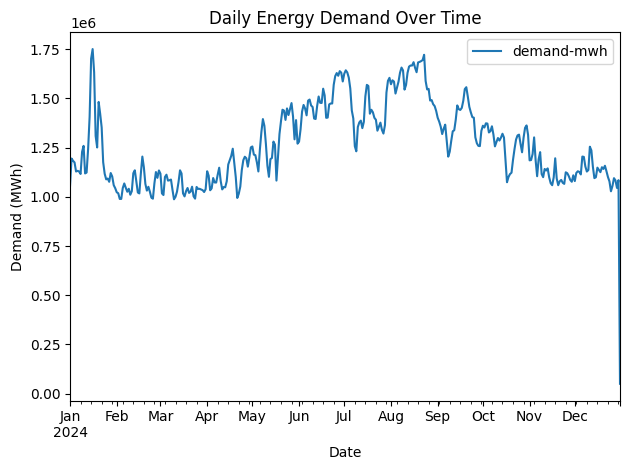

In [249]:
daily_demand.plot(title='Daily Energy Demand Over Time', xlabel='Date', ylabel='Demand (MWh)')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Weekly Energy Demand Over Time'}, xlabel='Date', ylabel='Demand (MWh)'>

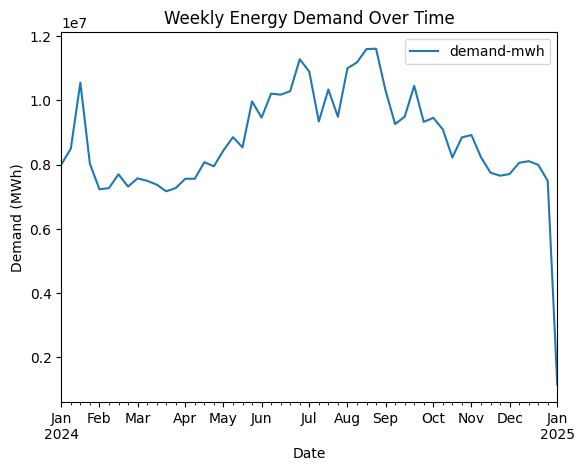

In [250]:
weekly_demand = EIA_clean_df.resample('W').sum()
weekly_demand.plot(title='Weekly Energy Demand Over Time', xlabel='Date', ylabel='Demand (MWh)')


In [251]:
weather_df = pd.read_csv('./data/raw/open_meteo.csv')
weather_df

,time,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),showers (mm),snowfall (cm),cloud_cover (%),wind_speed_10m (km/h)
0,2024-01-01T00:00,-9.0,44,-14.8,0.0,0.0,0.0,0,14.0
1,2024-01-01T01:00,-8.8,44,-14.7,0.0,0.0,0.0,0,14.3
2,2024-01-01T02:00,-8.5,44,-14.4,0.0,0.0,0.0,0,14.5
3,2024-01-01T03:00,-8.0,44,-13.8,0.0,0.0,0.0,0,13.8
4,2024-01-01T04:00,-7.1,43,-12.5,0.0,0.0,0.0,0,11.6
...,...,...,...,...,...,...,...,...,...
8779,2024-12-31T19:00,-6.4,56,-11.4,0.0,0.0,0.0,0,10.3
8780,2024-12-31T20:00,-6.6,51,-11.9,0.0,0.0,0.0,0,11.5
8781,2024-12-31T21:00,-6.8,50,-12.1,0.0,0.0,0.0,0,11.9
8782,2024-12-31T22:00,-7.1,49,-12.5,0.0,0.0,0.0,0,12.1


In [252]:
weather_df['time'] = pd.to_datetime(weather_df['time'],utc=True )
weather_df = weather_df.set_index('time').sort_index()

In [253]:
houston_weather_df = weather_df

In [254]:

merged_df = pd.merge(EIA_clean_df, weather_df, left_index=True, right_index=True, how='inner')
merged_df

,demand-mwh,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),showers (mm),snowfall (cm),cloud_cover (%),wind_speed_10m (km/h)
2024-01-01 00:00:00+00:00,44394,-9.0,44,-14.8,0.0,0.0,0.0,0,14.0
2024-01-01 01:00:00+00:00,45855,-8.8,44,-14.7,0.0,0.0,0.0,0,14.3
2024-01-01 02:00:00+00:00,44887,-8.5,44,-14.4,0.0,0.0,0.0,0,14.5
2024-01-01 03:00:00+00:00,44012,-8.0,44,-13.8,0.0,0.0,0.0,0,13.8
2024-01-01 04:00:00+00:00,43279,-7.1,43,-12.5,0.0,0.0,0.0,0,11.6
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00+00:00,48595,-5.9,64,-10.4,0.0,0.0,0.0,10,7.4
2024-12-30 21:00:00+00:00,49602,-6.1,65,-10.7,0.0,0.0,0.0,10,8.4
2024-12-30 22:00:00+00:00,50245,-6.4,65,-11.0,0.0,0.0,0.0,0,8.4
2024-12-30 23:00:00+00:00,50334,-6.7,63,-11.4,0.0,0.0,0.0,0,9.2


In [255]:
merged_df.describe()


,demand-mwh,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),showers (mm),snowfall (cm),cloud_cover (%),wind_speed_10m (km/h)
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,52816.682114,1.964901,84.373816,-1.150371,0.127132,0.048625,0.099787,81.055701,8.387501
std,10531.635878,5.844915,18.257008,7.080194,0.420206,0.182732,0.260311,32.784614,4.533835
min,36190.000000,-11.500000,8.000000,-17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45028.000000,-3.200000,79.000000,-7.400000,0.000000,0.000000,0.000000,80.000000,5.200000
50%,49903.000000,1.800000,91.000000,-1.300000,0.000000,0.000000,0.000000,100.000000,7.600000
75%,58962.000000,7.200000,98.000000,5.100000,0.000000,0.000000,0.000000,100.000000,10.500000
max,85544.000000,16.600000,100.000000,16.300000,4.800000,2.500000,3.010000,100.000000,41.500000


In [256]:
merged_df.interpolate()

,demand-mwh,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),showers (mm),snowfall (cm),cloud_cover (%),wind_speed_10m (km/h)
2024-01-01 00:00:00+00:00,44394,-9.0,44,-14.8,0.0,0.0,0.0,0,14.0
2024-01-01 01:00:00+00:00,45855,-8.8,44,-14.7,0.0,0.0,0.0,0,14.3
2024-01-01 02:00:00+00:00,44887,-8.5,44,-14.4,0.0,0.0,0.0,0,14.5
2024-01-01 03:00:00+00:00,44012,-8.0,44,-13.8,0.0,0.0,0.0,0,13.8
2024-01-01 04:00:00+00:00,43279,-7.1,43,-12.5,0.0,0.0,0.0,0,11.6
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00+00:00,48595,-5.9,64,-10.4,0.0,0.0,0.0,10,7.4
2024-12-30 21:00:00+00:00,49602,-6.1,65,-10.7,0.0,0.0,0.0,10,8.4
2024-12-30 22:00:00+00:00,50245,-6.4,65,-11.0,0.0,0.0,0.0,0,8.4
2024-12-30 23:00:00+00:00,50334,-6.7,63,-11.4,0.0,0.0,0.0,0,9.2


In [257]:
merged_df['3DMA_demand'] = merged_df['demand-mwh'].rolling(window=168).mean()
merged_df

,demand-mwh,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),rain (mm),showers (mm),snowfall (cm),cloud_cover (%),wind_speed_10m (km/h),3DMA_demand
2024-01-01 00:00:00+00:00,44394,-9.0,44,-14.8,0.0,0.0,0.0,0,14.0,NaN
2024-01-01 01:00:00+00:00,45855,-8.8,44,-14.7,0.0,0.0,0.0,0,14.3,NaN
2024-01-01 02:00:00+00:00,44887,-8.5,44,-14.4,0.0,0.0,0.0,0,14.5,NaN
2024-01-01 03:00:00+00:00,44012,-8.0,44,-13.8,0.0,0.0,0.0,0,13.8,NaN
2024-01-01 04:00:00+00:00,43279,-7.1,43,-12.5,0.0,0.0,0.0,0,11.6,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00+00:00,48595,-5.9,64,-10.4,0.0,0.0,0.0,10,7.4,44425.285714
2024-12-30 21:00:00+00:00,49602,-6.1,65,-10.7,0.0,0.0,0.0,10,8.4,44438.220238
2024-12-30 22:00:00+00:00,50245,-6.4,65,-11.0,0.0,0.0,0.0,0,8.4,44455.172619
2024-12-30 23:00:00+00:00,50334,-6.7,63,-11.4,0.0,0.0,0.0,0,9.2,44471.142857


In [258]:
import matplotlib.pyplot as plt

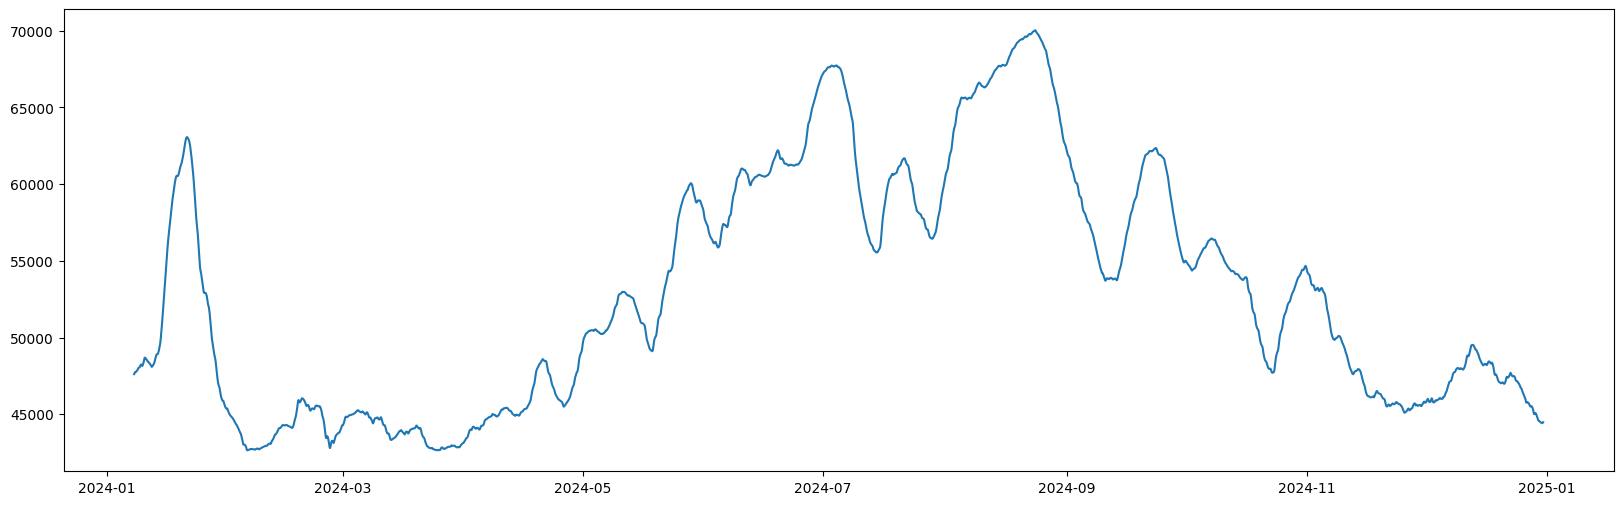

In [259]:
plt.figure(figsize=(20, 6))
plt.plot(merged_df['3DMA_demand'])

we see a increase in demand during the summer months

In [265]:
merged_df.index = merged_df.index.tz_convert('America/Chicago') 

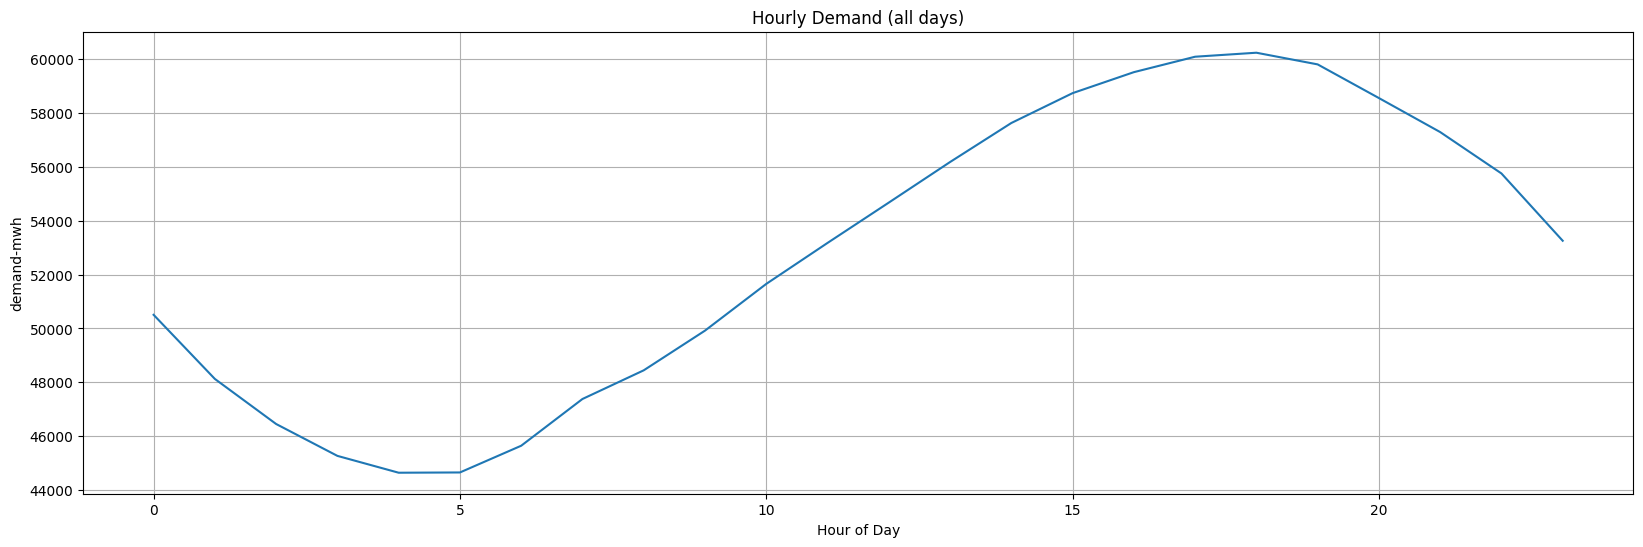

In [266]:
merged_df['hour'] = merged_df.index.hour
merged_df['day'] = merged_df.index.weekday + 1
fig, ax = plt.subplots(figsize=(20,6))

hourly_avg = merged_df.groupby('hour')['demand-mwh'].mean()
hourly_avg.plot(title='Hourly Demand (all days)')
plt.xlabel('Hour of Day')
plt.ylabel('demand-mwh')
plt.grid()
plt.show()

this confirms that there is a daily cycle

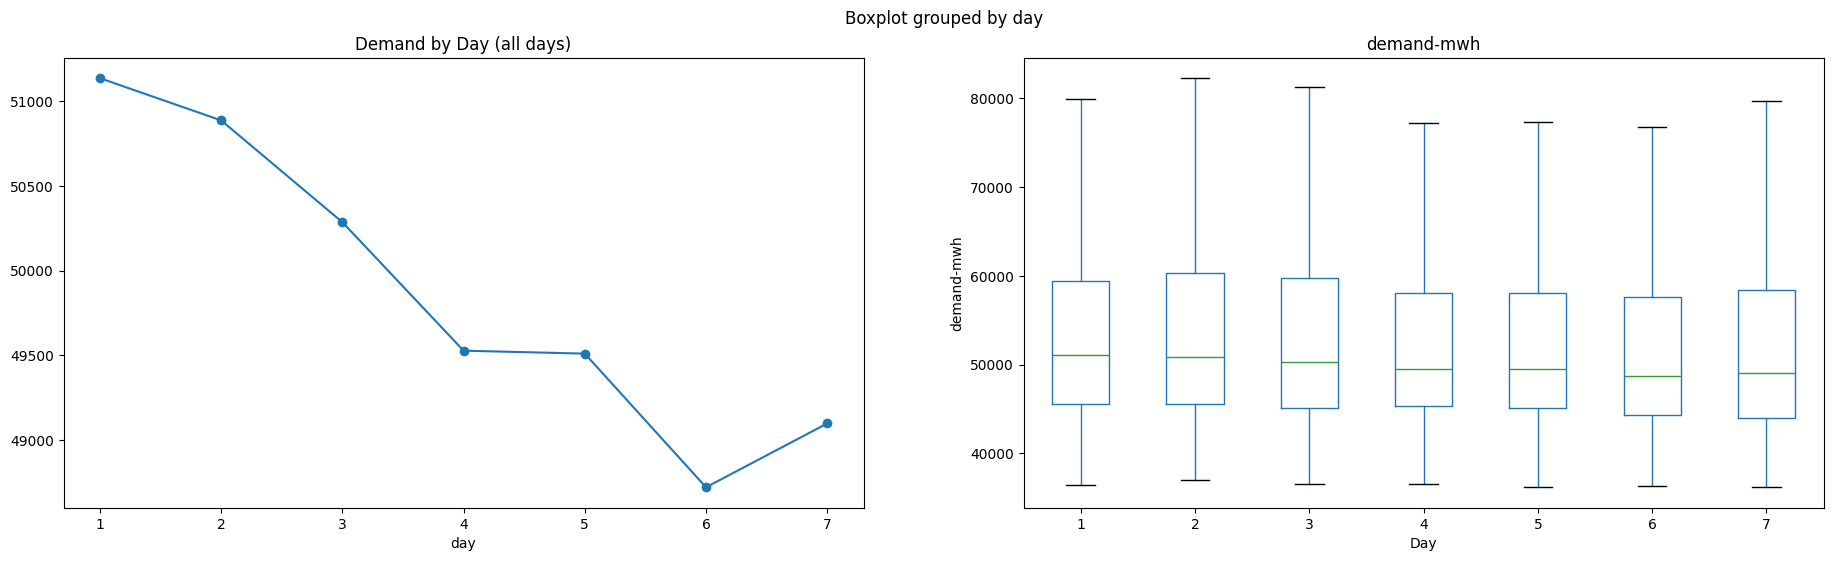

In [268]:
hourly_avg = merged_df.groupby('day')['demand-mwh'].median()

fig, ax = plt.subplots(1,2,figsize=(22,6))
hourly_avg.plot(title='Demand by Day (all days)',ax=ax[0], style='o-')
merged_df.boxplot(column='demand-mwh', by='day', ax=ax[1],showfliers=False)
plt.xlabel('Day')
plt.ylabel('demand-mwh')
plt.grid()
plt.show()

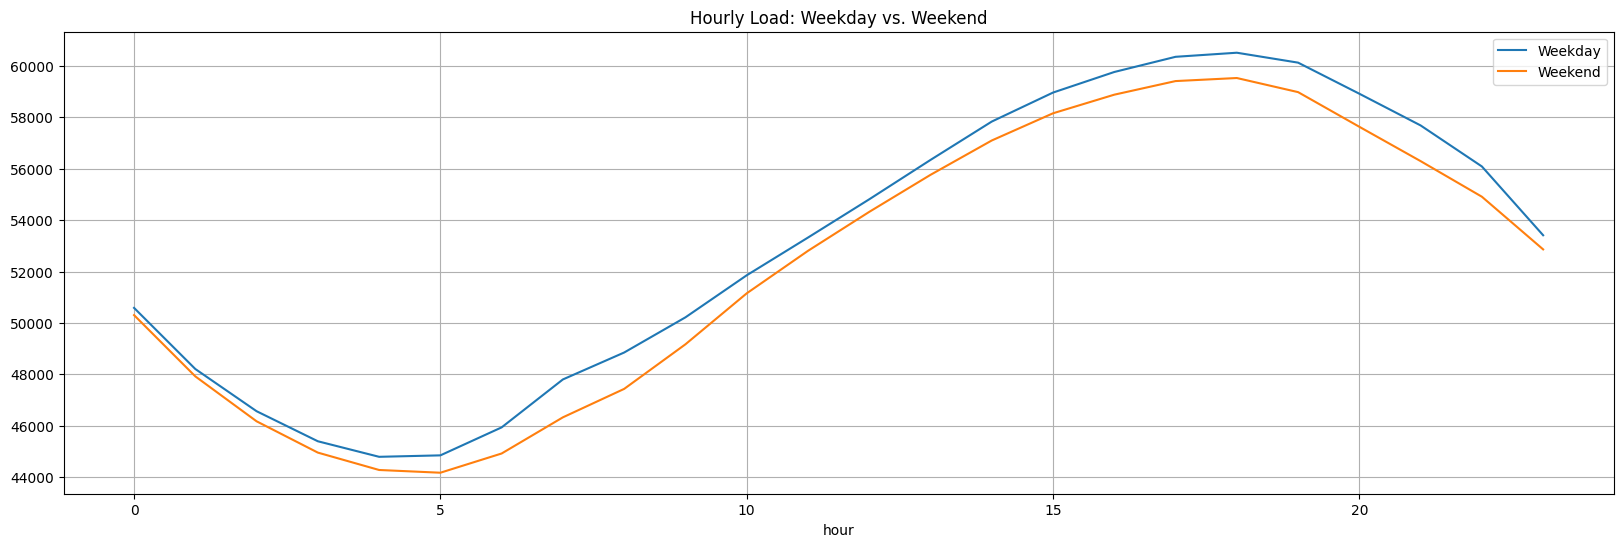

In [267]:
merged_df['is_weekend'] = merged_df['day'].isin([5, 6])  # 5=Saturday, 6=Sunday

weekday_hourly = merged_df[~merged_df['is_weekend']].groupby('hour')['demand-mwh'].mean()
weekend_hourly = merged_df[merged_df['is_weekend']].groupby('hour')['demand-mwh'].mean()

plt.figure(figsize=(20, 6))
weekday_hourly.plot(label='Weekday')
weekend_hourly.plot(label='Weekend')
plt.title('Hourly Load: Weekday vs. Weekend')
plt.legend()
plt.grid()
plt.show()

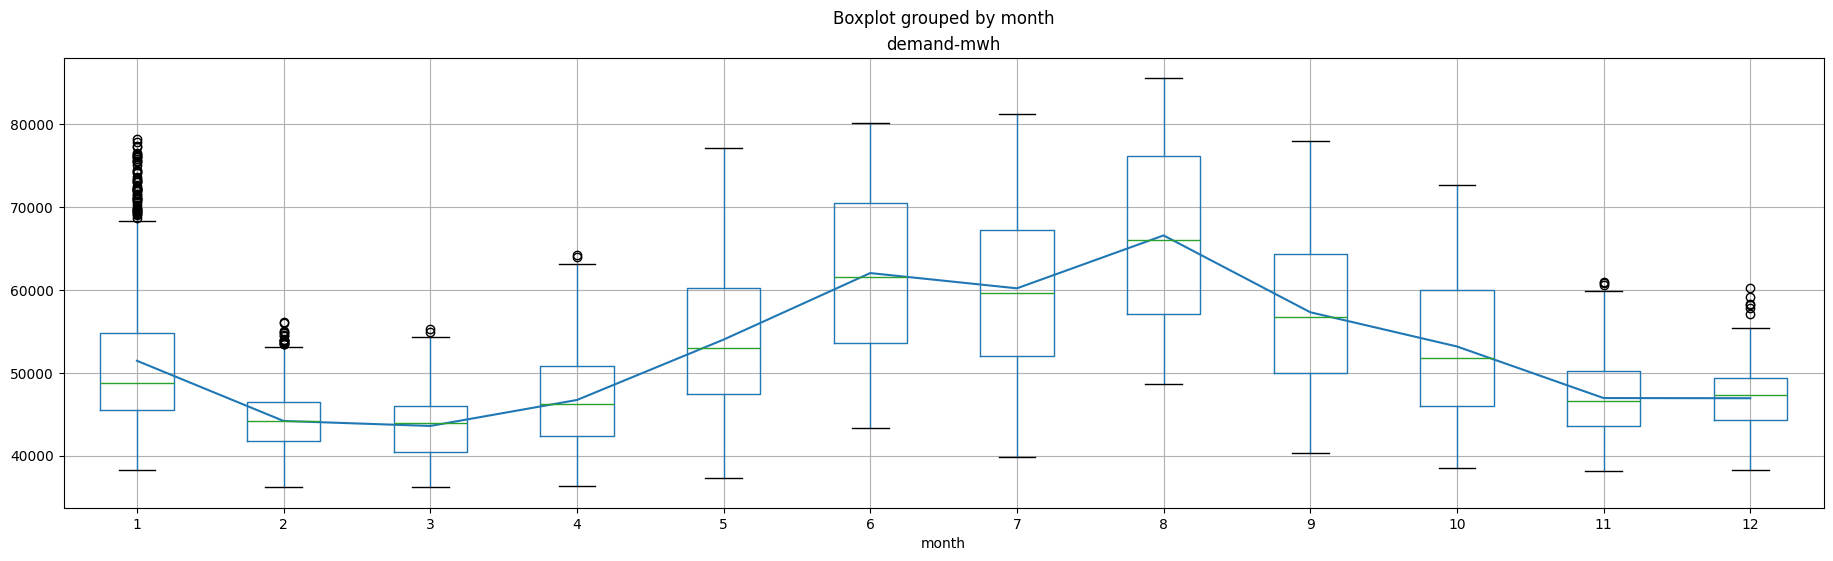

In [269]:
fig, ax =plt.subplots(figsize= (22,6))


merged_df['month'] = merged_df.index.month
monthly_avg = merged_df.groupby('month')['demand-mwh'].mean()

merged_df.boxplot(column='demand-mwh', by = 'month', ax=ax)
monthly_avg.plot(label='Month', ax=ax)
plt.grid()
plt.show()




demand peaks in the summer

In [264]:
print(merged_df.index.tz) 

UTC
